# Regression Models

## Imports

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.metrics import mean_squared_error

from yellowbrick.regressor import PredictionError

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nbimporter

import TrainTestEvalSplit as split
from sklearn.model_selection import KFold

import pickle

Importing Jupyter notebook from TrainTestEvalSplit.ipynb


## Import File

In [2]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Full.csv")
full_df["Date"] = pd.to_datetime(full_df["Date"], format="%Y-%m-%d")

full_df.head()

,Date,Hour,Nieuwmarkt Arrivals,Nieuwezijds Kolk Arrivals,Dam Arrivals,Spui Arrivals,Nieuwmarkt Departures,Nieuwezijds Kolk Departures,Dam Departures,Spui Departures,...,SensorLatitude,CrowdednessCount,is_event,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,2018-03-11,100,0.0,0.0,13.0,0.0,0.0,0.0,90.0,0.0,...,5,886,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,0.258819,0.965926
1,2018-03-11,2100,136.0,80.0,409.0,40.0,211.0,119.0,858.0,94.0,...,7,1603,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-0.707107,0.707107
2,2018-03-11,2100,136.0,80.0,409.0,40.0,211.0,119.0,858.0,94.0,...,0,21,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-0.707107,0.707107
3,2018-03-11,2100,136.0,80.0,409.0,40.0,211.0,119.0,858.0,94.0,...,9,88,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-0.707107,0.707107
4,2018-03-11,2100,136.0,80.0,409.0,40.0,211.0,119.0,858.0,94.0,...,2,49,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-0.707107,0.707107


## Train/Test/Eval split

In [3]:
size = 0.9
sensor = "GAWW-02"
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [4]:
x_train, y_train, x_test, y_test, x_test_series, y_test_series, feature_labels, train_dates = split.trainTestSplit(full_df, size, sensor)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Models

### Baseline: Linear Regression
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

#### Training

In [5]:
base = LinearRegression(n_jobs=10, normalize=True)

In [6]:
mean_score = 0
mean_rmse = 0

for train_index, val_index in kf.split(train_dates):
    base.fit(x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}))
    
    mean_score += base.score(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}))
    
    y_pred_base = base.predict(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}))
    mean_rmse += np.sqrt(mean_squared_error(y_pred_base, 
                                            y_train[y_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"})))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

Average R^2 Score:  0.32209681209379165
Average RMSE Score:  809.486009035834


#### Test

R^2 Score:  0.32413885294730216
RMSE:  792.6173203962392


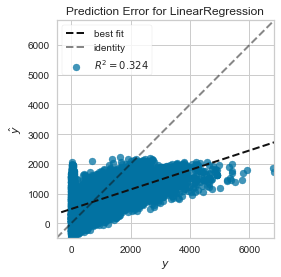

In [8]:
test_base_score = base.score(x_test, y_test)

y_pred_test_base = base.predict(x_test)
test_base_mse = mean_squared_error(y_pred_test_base, y_test)

print("R^2 Score: ", test_base_score)
print("RMSE: ", np.sqrt(test_base_mse))

visualizer = PredictionError(base)
visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

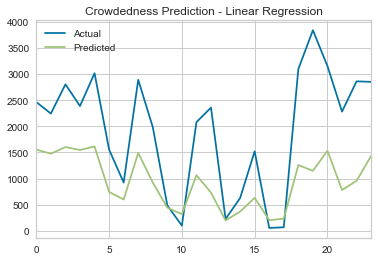

In [9]:
#Time series
time_pred_test_base = base.predict(x_test_series)

time_pred_series_test_base = pd.Series(time_pred_test_base)
time_real_series_test_base = pd.Series(y_test_series)

time_real_series_test_base.plot(legend=True, label="Actual")
time_pred_series_test_base.plot(legend=True, title='Crowdedness Prediction - Linear Regression', label="Predicted")
plt.show()

### Random Forrest Regressor 
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

#### Training

In [11]:
rfg = RandomForestRegressor(n_estimators=500, criterion="mse", n_jobs=100, random_state=42, bootstrap=True, 
                               oob_score=True)

In [12]:
mean_score = 0
mean_rmse = 0

for train_index, val_index in kf.split(train_dates):
    rfg.fit(x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}))
    
    mean_score += rfg.score(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}))
    
    y_pred_rfg = rfg.predict(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}))
    mean_rmse += np.sqrt(mean_squared_error(y_pred_rfg, 
                                            y_train[y_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"})))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
D:\Programs\Anaconda\envs\Analytics\lib\site-package

Average R^2 Score:  0.8866706605137541
Average RMSE Score:  326.50179788017215


#### Test

R^2 Score:  0.8983099401414647
RMSE:  307.4496969719268


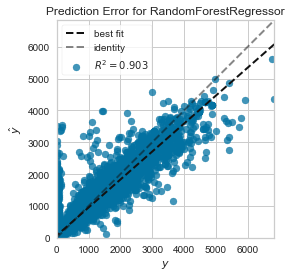

In [13]:
test_rfg_score = rfg.score(x_test, y_test)

y_pred_test_rfg = rfg.predict(x_test)
test_rfg_mse = mean_squared_error(y_pred_test_rfg, y_test)

print("R^2 Score: ", test_rfg_score)
print("RMSE: ", np.sqrt(test_rfg_mse))

visualizer = PredictionError(rfg)
visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"])  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

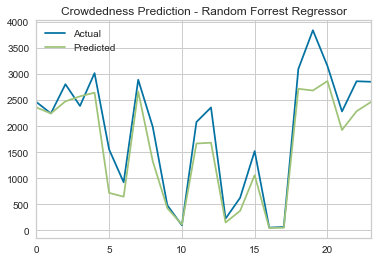

In [14]:
#Time series
time_pred_test_rfg = rfg.predict(x_test_series)

time_pred_series_test_rfg = pd.Series(time_pred_test_rfg)
time_real_series_test_rfg = pd.Series(y_test_series)

time_real_series_test_rfg.plot(legend=True, label="Actual")
time_pred_series_test_rfg.plot(legend=True, title='Crowdedness Prediction - Random Forrest Regressor', label="Predicted")
plt.show()

#### Save Model

In [16]:
filename = "../../../Data_thesis/Models/rfg_model.sav"

pickle.dump(rfg, open(filename, 'wb'))

### XGBoost Regressor
Through [SciKit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html) 

#### Training

In [16]:
xgbr = xgb.XGBRegressor(max_depth=6, learning_rate=0.08, n_estimators=500, verbosity=1,
                          booster="gbtree", n_jobs=50, random_state=42)

In [17]:
mean_score = 0
mean_rmse = 0

for train_index, val_index in kf.split(train_dates):
    xgbr.fit(x_train[x_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[train_index])].drop(columns={"Date"}))
    
    mean_score += xgbr.score(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}),
             y_train[y_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}))
    
    y_pred_xgbr = xgbr.predict(x_train[x_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"}))
    mean_rmse += np.sqrt(mean_squared_error(y_pred_xgbr, 
                                            y_train[y_train["Date"].isin(train_dates[val_index])].drop(columns={"Date"})))

mean_score /= 10
mean_rmse /= 10

print("Average R^2 Score: ", mean_score)
print("Average RMSE Score: ", mean_rmse)

Average R^2 Score:  0.8910427390726768
Average RMSE Score:  320.1076488462232


#### Test

R^2 Score:  0.8971622297556964
RMSE:  309.1798225856342


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


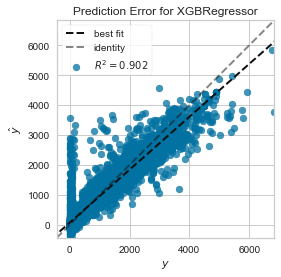

In [20]:
test_xgbr_score = xgbr.score(x_test, y_test)

y_pred_test_xgbr = xgbr.predict(x_test)
test_xgbr_mse = mean_squared_error(y_pred_test_xgbr, y_test)

print("R^2 Score: ", test_xgbr_score)
print("RMSE: ", np.sqrt(test_xgbr_mse))

visualizer = PredictionError(xgbr)
visualizer.fit(x_train.drop(columns={"Date"}), y_train["CrowdednessCount"]) # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof() 

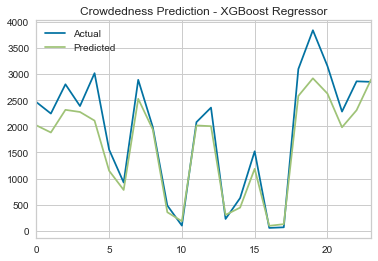

In [21]:
#Time series
time_pred_test_xgbr = xgbr.predict(x_test_series)

time_pred_series_test_xgbr = pd.Series(time_pred_test_xgbr)
time_real_series_test_xgbr = pd.Series(y_test_series)

time_real_series_test_xgbr.plot(legend=True, label="Actual")
time_pred_series_test_xgbr.plot(legend=True, title='Crowdedness Prediction - XGBoost Regressor', label="Predicted")
plt.show()

#### Save model to File

In [18]:
filename = "../../../Data_thesis/Models/xgbr_model.sav"

pickle.dump(xgbr, open(filename, 'wb'))